# Kanji Radical Match

Loading data, training, and output.

In [1]:
import utils as u
import torch.nn as nn
import torch
from utils import KanjiFFNN
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [2]:
eng_to_rads = u.load_eng_to_rads()
eng_tens, rad_tens, eng_vocab, rad_vocab = u.dict_to_tensors(eng_to_rads)

In [ ]:
eng_to_rads

In [3]:
print("Vocabulary size:", len(eng_vocab))
print("Radical vocabulary size:", len(rad_vocab))

Vocabulary size: 5191
Radical vocabulary size: 793


In [4]:
# Print a small sample of our data
print(eng_tens[:5])
print(eng_vocab[:5])
print(rad_tens[:5])
print(rad_vocab[:5])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['%' '(kokuji)' '(north) korea' '(parallels of) latitude' '-']
tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['⺌' '⺍' '⺕' '⺗' '⺤']


In [5]:
# Example
print(u.get_tensor_from_word("eight", eng_tens, eng_vocab))

tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [9]:
e2r_model = KanjiFFNN(eng_tens.size(1), rad_tens.size(1), 20)
criterion = nn.BCELoss()
optimizer = optim.Adam(e2r_model.parameters(), lr=1e-3)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [10]:
epochs = 20

e2r_model.train_fit(eng_tens, rad_tens, optimizer, criterion, epochs=epochs, scheduler=lr_scheduler, verbose=True)

Epoch        1 Loss: 0.01779271475970745
Epoch        2 Loss: 0.018035070970654488
Epoch        3 Loss: 0.01809585653245449
Epoch        4 Loss: 0.018127745017409325
Epoch        5 Loss: 0.018097497522830963
Epoch        6 Loss: 0.018011782318353653
Epoch        7 Loss: 0.017864001914858818
Epoch        8 Loss: 0.017667029052972794
Epoch        9 Loss: 0.01743856817483902
Epoch       10 Loss: 0.017196353524923325
Epoch       11 Loss: 0.016912061721086502
Epoch       12 Loss: 0.01660681702196598
Epoch       13 Loss: 0.01628638617694378
Epoch       14 Loss: 0.01598465070128441
Epoch       15 Loss: 0.01571967639029026
Epoch       16 Loss: 0.015464523807168007
Epoch       17 Loss: 0.015219416469335556
Epoch       18 Loss: 0.01499356422573328
Epoch       19 Loss: 0.014801363460719585
Epoch       20 Loss: 0.014638739638030529


In [12]:
torch.save(e2r_model, "./models/model.pt")

In [13]:
torch.save(e2r_model.state_dict(), "./models/model_state_dict.pt")

In [6]:
loaded_model = KanjiFFNN(eng_tens.size(1), rad_tens.size(1), 20)
loaded_model.load_state_dict(torch.load("./models/model_state_dict.pt"))
loaded_model.eval()

KanjiFFNN(
  (hid1): Linear(in_features=10, out_features=20, bias=True)
  (hid2): Linear(in_features=20, out_features=19, bias=True)
)

In [14]:
tensor = u.get_tensor_from_word("eight", eng_tens, eng_vocab)
res = e2r_model(tensor)
print(res)

tensor([3.3006e-06, 2.9419e-05, 8.0585e-05, 1.4043e-07, 2.4051e-05, 1.1260e-05,
        3.1942e-05, 8.2321e-05, 2.1655e-05, 1.2333e-04, 1.7412e-06, 2.7313e-06,
        1.2714e-10, 6.1793e-07, 1.1664e-06, 3.3734e-04, 4.3744e-05, 1.4098e-06,
        5.4120e-07, 1.1365e-07, 7.4708e-10, 3.8422e-05, 1.3607e-06, 1.9735e-07,
        6.1500e-07, 1.2360e-07, 9.4969e-10, 4.5623e-05, 1.3106e-07, 1.4099e-08,
        1.0739e-06, 2.2381e-06, 2.2593e-08, 1.6030e-04, 9.8060e-07, 2.5382e-05,
        9.3901e-07, 2.2115e-09, 1.3374e-04, 2.7385e-07, 1.8617e-05, 1.7481e-04,
        4.4677e-05, 1.6085e-07, 1.7124e-08, 2.0308e-06, 1.7465e-07, 3.4764e-06,
        1.0072e-07, 1.2314e-09, 4.9292e-08, 1.2826e-05, 1.7973e-05, 2.1894e-08,
        4.9283e-06, 1.1912e-05, 7.1895e-07, 5.8640e-06, 2.1686e-07, 7.1101e-05,
        3.6380e-07, 1.4035e-05, 2.3529e-06, 1.1152e-06, 3.1096e-07, 1.0855e-06,
        1.7435e-04, 5.0872e-06, 1.1979e-06, 7.6232e-06, 8.2398e-06, 3.9470e-06,
        2.2316e-09, 1.5657e-06, 4.4006e-

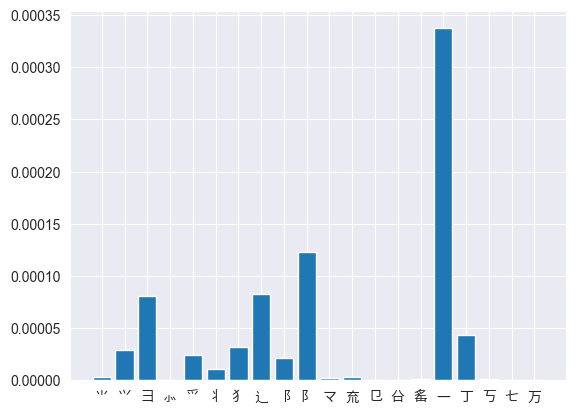

In [19]:
fprop = fm.FontProperties(fname='NotoSansCJKtc-Regular.otf')
radicals = rad_vocab[:20]
probabilities = res.tolist()[:20]

fig, axs = plt.subplots()
axs.bar(radicals, probabilities)
axs.set_xticks(range(len(radicals)), radicals, fontproperties=fprop)
plt.show()